# Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на paired данных. Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов.

В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля.

In [1]:
import os

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch

from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize

In [2]:
DATA_PATH = 'facades'
BATCH_SIZE = 4
NUM_WORKERS = 16

MEAN = [0.4145, 0.4200, 0.3955]
STD = [0.2889, 0.2716, 0.2566]

LABELS_MEAN = [0.15027801, 0.28054181, 0.81202195]
LABELS_STD = [0.28346735, 0.25603573, 0.31767057]

In [3]:
joined = imageio.imread(os.path.join(DATA_PATH, 'train', '1.jpg'))
img, mask = joined[:, :256, :], joined[:, 256:, :]

In [4]:
joined.shape

(256, 512, 3)

In [5]:
class FacadesDataset(Dataset):
    def __init__(self, data_path, split, transforms=None):
        self.transforms = transforms
        n_images = len(os.listdir(os.path.join(DATA_PATH, split)))
        self.images = np.zeros((n_images, 256, 256, 3), dtype=np.uint8)
        self.labels = np.zeros((n_images, 256, 256, 3), dtype=np.uint8)
        for i in range(1, n_images+1):
            joined = imageio.imread(os.path.join(DATA_PATH, split, f'{i}.jpg'))
            image, label = joined[:, :256, :], joined[:, 256:, :]
            
            self.images[i - 1] = image
            self.labels[i - 1] = label
        self.images = self.images
        self.labels = self.labels

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transforms is not None:
            image, label = self.transforms(image, label)
        image = normalize(to_tensor(image), mean=MEAN, std=STD)
        label = normalize(to_tensor(label), mean=LABELS_MEAN, std=LABELS_STD)
        return {'image': image, 'label': label}
    
    def __len__(self):
        return len(self.images)

In [6]:
def train_transforms(image, labels):
    aug = iaa.Sequential([
        iaa.flip.Fliplr(p=0.5),
        iaa.flip.Flipud(p=0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)},
            rotate=(-180, 180),
            shear=(20, 20),
            mode='reflect'
        ),
    ], random_order=False)
    
    aug_deterministic = aug.to_deterministic()
    image = aug_deterministic.augment(image=image)
    labels = aug_deterministic.augment(image=labels)
    
    return image, labels

In [7]:
train_dataset = FacadesDataset(DATA_PATH, 'train', train_transforms)
valid_dataset = FacadesDataset(DATA_PATH, 'val')
test_dataset = FacadesDataset(DATA_PATH, 'test')

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS,
#     drop_last=True
# )

# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS
# )
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [8]:
class Pix2PixDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, valid_dataset, test_dataset, batch_size, num_workers):
        super().__init__()
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

In [11]:
class Pix2Pix(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.generator = smp.Unet(
            encoder_name='resnet18',
            encoder_weights='imagenet',
            in_channels=3,
            classes=3,
        )
        # для того, чтобы определить, настоящее пара изображение-маска или нет будем объединять их по каналам
        self.discriminator = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1, 3, padding=1)
        )
        
    def forward(self, x):
        return self.generator(x)
    
    def _set_requires_grad(self, parameters, value):
        for parameter in parameters:
                parameter.requires_grad = value
        
                
    def training_step(self, batch, batch_idx, optimizer_idx):
        image = batch["image"]
        label = batch["label"]
        
        fake_image = self.generator(label)
        
        # generator
        if optimizer_idx == 0:
            self._set_requires_grad(self.discriminator.parameters(), False)
            d_pred_fake = self.discriminator(torch.cat([label, fake_image], dim=1))
            
            g_loss = (
                F.mse_loss(d_pred_fake, torch.ones_like(d_pred_fake)) + 
                F.l1_loss(image, fake_image)
            )
            
            self.log('g_loss', g_loss, on_epoch=True, prog_bar=True)
            return g_loss
        
        # discriminator
        elif optimizer_idx == 1:
            self._set_requires_grad(self.discriminator.parameters(), True)
            
            d_pred_orig = self.discriminator(torch.cat([label, image], dim=1))
            d_pred_fake = self.discriminator(torch.cat([label, fake_image.detach()], dim=1))
            
            d_loss = F.mse_loss(
                torch.cat([d_pred_orig, d_pred_fake]),
                torch.cat([torch.ones_like(d_pred_orig), torch.zeros_like(d_pred_fake)])
            )
            
            self.log('d_loss', d_loss, on_epoch=True, prog_bar=True)
            return d_loss
    
    def validation_step(self, batch, batch_idx):
        image = batch["image"]
        label = batch["label"]
        
        fake_image = self.generator(label)
        
        d_pred_fake = self.discriminator(torch.cat([label, fake_image], dim=1))
        d_pred_orig = self.discriminator(torch.cat([label, image], dim=1))
        
        g_loss_val = (
            F.mse_loss(d_pred_fake, torch.ones_like(d_pred_fake)) + 
            F.l1_loss(image, fake_image)
        )
        
        d_loss_val = F.mse_loss(
            torch.cat([d_pred_orig, d_pred_fake]),
            torch.cat([torch.ones_like(d_pred_orig), torch.zeros_like(d_pred_fake)])
        )
        self.log('g_loss_val', g_loss_val, on_epoch=True, prog_bar=True)
        self.log('d_loss_val', d_loss_val, on_epoch=True, prog_bar=True)
        
        if not batch_idx:
            self.logger.experiment.add_image(
                'Fake image', fake_image[0], self.current_epoch, dataformats = "CHW"
            )
        
    
    def configure_optimizers(self):
        optimizer_g = optim.Adam(self.generator.parameters(), lr=1e-4)
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=1e-4)
        scheduler_g = optim.lr_scheduler.ExponentialLR(optimizer_g, 0.5)
        scheduler_d = optim.lr_scheduler.ExponentialLR(optimizer_g, 0.5)
        return [optimizer_g, optimizer_d], []

In [12]:
dm = Pix2PixDataModule(
    train_dataset,
    valid_dataset,
    test_dataset,
    BATCH_SIZE,
    NUM_WORKERS
)

model = Pix2Pix()

checkpoint_callback = ModelCheckpoint(monitor='g_loss_val', verbose=True, save_last=True)

trainer = pl.Trainer(
    gpus=[1],
    checkpoint_callback=checkpoint_callback,
    deterministic=True,
    max_epochs=20
)

trainer.fit(model, datamodule=dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type       | Params
---------------------------------------------
0 | generator     | Unet       | 14.3 M
1 | discriminator | Sequential | 1.3 M 
---------------------------------------------
15.7 M    Trainable params
0         Non-trainable params
15.7 M    Total params


Epoch 0, global step 99: g_loss_val reached 1.14891 (best 1.14891), saving model to "/home/xfs/Downloads/playground/adl/lightning_logs/version_11/checkpoints/epoch=0-step=99.ckpt" as top 1


Epoch 1, step 199: g_loss_val was not in top 1


Epoch 2, step 299: g_loss_val was not in top 1


Epoch 3, step 399: g_loss_val was not in top 1


Epoch 4, global step 499: g_loss_val reached 1.01912 (best 1.01912), saving model to "/home/xfs/Downloads/playground/adl/lightning_logs/version_11/checkpoints/epoch=4-step=499.ckpt" as top 1


Epoch 5, step 599: g_loss_val was not in top 1


Epoch 6, step 699: g_loss_val was not in top 1


Epoch 7, step 799: g_loss_val was not in top 1


Epoch 8, step 899: g_loss_val was not in top 1


Epoch 9, step 999: g_loss_val was not in top 1


Epoch 10, step 1099: g_loss_val was not in top 1


Epoch 11, step 1199: g_loss_val was not in top 1


Epoch 12, step 1299: g_loss_val was not in top 1


Epoch 13, step 1399: g_loss_val was not in top 1


Epoch 14, step 1499: g_loss_val was not in top 1
Saving latest checkpoint...
Epoch 15, step 1505: g_loss_val was not in top 1


1

In [13]:
model.eval()
model.freeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


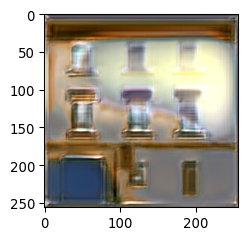

In [31]:
with torch.no_grad():
    fake_image = model(test_dataset[45]['label'].unsqueeze(0))
ia.imshow((fake_image.squeeze(0).permute(1,2,0).numpy() * STD + MEAN))

Если приглядеться, то можно увидеть оконные рамы. Но сеть не доучилась.